# 4. Creating Fallback and branching pipelines

In this notebook, we will create a branching pipeline. The pipeline will first attempt to retrieve specific data stored in a document store and if the information is not found there, it will branch to a fallback mechanism that performs a web search to find the required information.

In [2]:
import sys

sys.path.append("..")

In [3]:
import warnings
import helper
import logging

logging.getLogger("haystack").setLevel(logging.ERROR)  
warnings.filterwarnings('ignore')
helper.load_env()

In [4]:
from haystack import Pipeline, Document
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.document_stores.in_memory import InMemoryDocumentStore

In ouy haystack_lib.py, we have included some components we like to use from before. We load it again : 

In [5]:
import haystack_lib

Our pipeline will hold three different choices when routing which direction follow in the pipeline:

1. The first condition will make the pipeline search the information in the in-memory store, for which we will previously index the documents there.
2. The second condition will be that if the information is not found in the in-memory store, we will fetch it from web search.
3. The third condition will be that once we have the information, we will pass it through a generator to generate a response.

Let's start indexing the documents to have the information ready for the retriever in our contitional pipeline :

### Index Documents into InMemoryDocumentStore

We will start preparing some dummy documents to store into our in-memory document store.

In [6]:
documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

### Create RAG Pipeline

In our first iteration of the RAG pipeline, we will create a prompt to handle two simple cases:

1. If the answer to the query is available in our in-memory store, we will return the answer.

2. If the condition is not met, the response will contain a "no answer" message.

In [7]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

llm = haystack_lib.MiniPHILLM()

rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag.add_component("llm", llm)

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: MiniPHILLM
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

We can see how the pipeline diagram is very similar to the ones we have done before, following a simple down-stream. We haven't yet implemented a fallback approach.

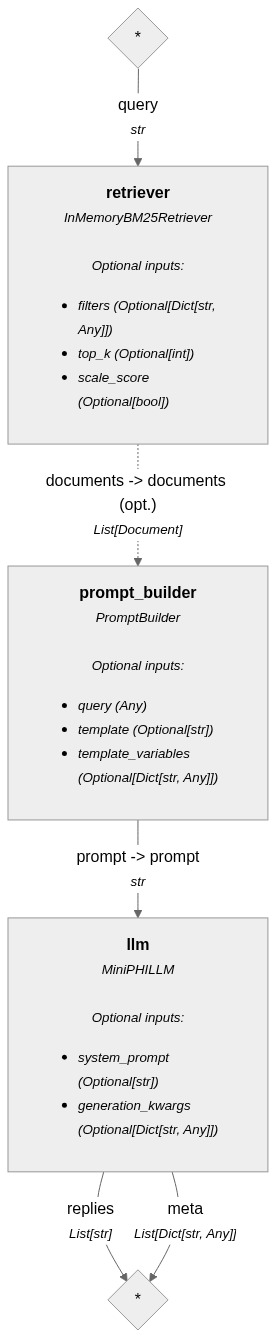

In [8]:
rag.show()

In [9]:
query = "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': [' Retrievers are used to retrieve relevant documents to a user query using keyword search or semantic search.'],
  'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 19,
     'prompt_tokens': 136,
     'total_tokens': 155,
     'completion_tokens_details': None,
     'prompt_tokens_details': None}}]}}

### Create Conditional Routes


We have our simple model up and running, but now we can try to go one step forward and add a [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai).

In [10]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

Let's test the component : 

In [11]:
router = ConditionalRouter(routes=routes)
router.run(replies=['Geoff is my friend'], query="Who is Geoff?")

{'answer': 'Geoff is my friend'}

In [12]:
router.run(replies=['No_answer'], query="Who is Geoff?")

{'go_to_websearch': 'Who is Geoff?'}

After running our first test, we can still add more components afterward.
Let's try to add the conditional router with the routes we have defined before.

In [13]:
router = ConditionalRouter(routes=routes)
rag.add_component("router", router)
rag.connect("llm.replies", "router.replies")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: MiniPHILLM
  - router: ConditionalRouter
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])

As we can see, now our pipeline doesn't just follow a down-stream process, it has a two branch process that will run simultaneously. The router component won't run its process until it has both conditions from its input met (or seen):

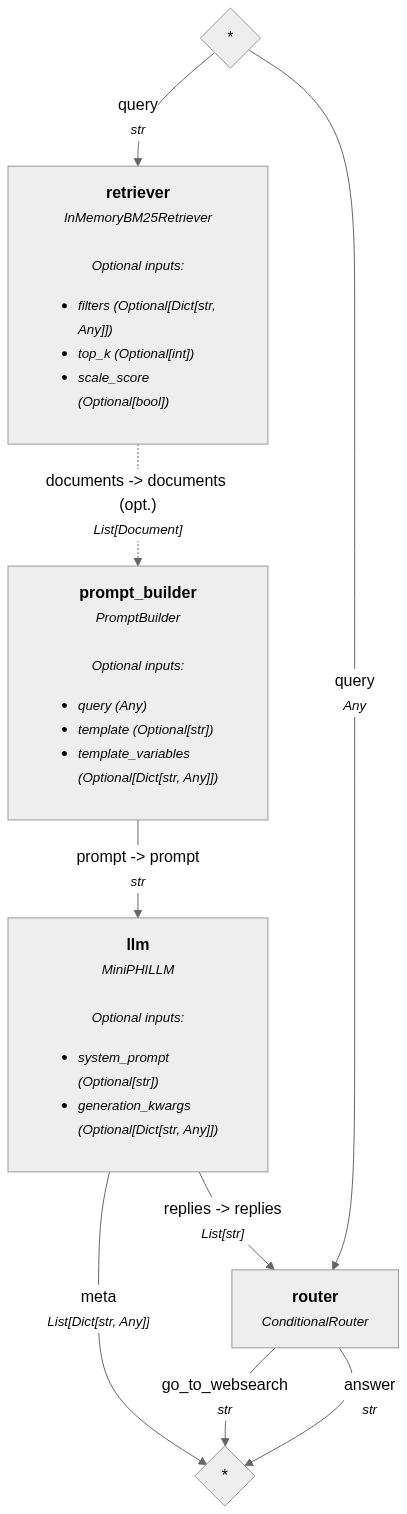

In [14]:
rag.show()

In [15]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query},
         "router": {"query": query}})

{'llm': {'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 138,
     'total_tokens': 141,
     'completion_tokens_details': None,
     'prompt_tokens_details': None}}]},
 'router': {'go_to_websearch': 'What Mistral components does Haystack have?'}}

This information is not hold in our in-memory store, so the router component shows what output is chosen : go to web search.

We don't have yet a function that works for web search, so we have to create one in order to expand our pipeline.

### Create Websearch Branch and buulding a Pipeline with conditional routes


Let's have a moment to think what we want our web search branch to do.

We want it to have an input that will enable this branch to start the web search. If this condition is met, we will retrieve information doing a quick web search, done in this case by the integrated component [`SerperDevWebSarch`](https://docs.haystack.deepset.ai/docs/serperdevwebsearch). This component will return us documents, our core data structure from Haystack and a URL from where the content is retrieved.


In [61]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
Whenever you use some information fetch from websearch, add a parenthesis with the source as (URL:)

Query: {{ query }}
Documents:
{% for document in documents %}
  {{ document.content }}
  URL: {{ document.metadata.url if document.metadata.url else "URL not available" }}
{% endfor %}
"""

First, let's ensure we have our serper key ready. At this moment, it is free to get a API key from [`Serper Dev`](https://serper.dev/?utm_term=serpapi&gad_source=1&gad_campaignid=18303173259&gbraid=0AAAAAo4ZGoFxeruC7_8eUKM0A7EVqW8cs&gclid=CjwKCAjwmenCBhA4EiwAtVjzmsj2RS7zqeCcjbns_1kq9YiQXYaCrSH_0c-hKOSKBWfi0Lj-5JDUwRoCg2QQAvD_BwE), which allow us to use up to 2500 queries for free using their API.

In [53]:
serper_key = helper.get_env_var("SERPER_KEY")

As I want the pipeline to include some links to show the source of the information, I will create a new component so we can have the links added to the documents, just as we had before with our Hacker News component :

In [55]:
from haystack import component
from haystack.dataclasses import Document
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from typing import List

@component
class SerperDevWebSearchMetadata:
    def __init__(self):
        self.searcher = SerperDevWebSearch()

    @component.output_types(documents=List[Document])
    def run(self, query: str) -> dict:
        output = self.searcher.run(query=query)
        documents = output["documents"]
        links = output["links"]

        wrapped_docs = []
        for doc, link in zip(documents, links):
            if not isinstance(doc, Document):
                doc = Document(content=str(doc))
            if not hasattr(doc, "metadata") or doc.metadata is None:
                doc.metadata = {}
            doc.metadata["url"] = link
            wrapped_docs.append(doc)

        return {"documents": wrapped_docs}

In [51]:
search = SerperDevWebSearchMetadata()
result = search.run(query="What Mistral components does Haystack have?")

for doc in result["documents"]:
    print("---")
    print("Content:", doc.content[:200])  
    print("URL:", doc.metadata.get("url"))

---
Content: Components. This instegration introduces 3 components: The MistralDocumentEmbedder : Creates embeddings for Haystack Documents using Mistral embedding models ( ...
URL: https://haystack.deepset.ai/integrations/mistral
---
Content: A component for computing Document embeddings using Mistral models. The embedding of each Document is stored in the embedding field of the Document.
URL: https://docs.haystack.deepset.ai/reference/integrations-mistral
---
Content: In summary, Mistral 7B is a powerful language model known for its efficiency and versatility in NLP tasks, Haystack is a flexible framework for ...
URL: https://www.e2enetworks.com/blog/rag-implementation-using-mistral-7b-haystack-and-weaviate
---
Content: Build a simple RAG chatbot in Python using Haystack, Haystack In-memory store, Mistral 7B, and OpenAI text-embedding-3-small.
URL: https://zilliz.com/tutorials/rag/haystack-and-haystack-in-memory-store-and-mistral-7b-and-openai-text-embedding-3-small
---
Content: In t

We can now build or new pipeline. Let's remember our specifications :

1. The pipeline will search in the in-memory store to try to find answers to the query it received.

 We have all the elements from the previous pipeline ( retriever, prompt builder and generator/llm), which we will use to feed the new branch of our conditional pipeline, starting from the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai).If the answer we are looking for is found within the in-memory store, we can see in our diagram how that is the answer that is returned to the user. 

2. If the information is not found in the in-memory store, we will fetch it from web search.
As the answer is not found locally, we will go through the next branch, from which we have added and connected the next elements : a prompt builder with a specific websearch template, a websearch component ( [`SerperDevWebSearch()`](https://docs.haystack.deepset.ai/docs/serperdevwebsearch)), and a new instance of a generator to elaborate the answer for the query.

In [62]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", haystack_lib.MiniPHILLM())
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearchMetadata())
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch", haystack_lib.MiniPHILLM())

rag_or_websearch.connect("retriever", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

#rag_or_websearch.show()

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: MiniPHILLM
  - router: ConditionalRouter
  - websearch: SerperDevWebSearchMetadata
  - prompt_builder_for_websearch: PromptBuilder
  - llm_for_websearch: MiniPHILLM
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websearch -> prompt_builder_for_websearch.query (str)
  - websearch.documents -> prompt_builder_for_websearch.documents (List[Document])
  - prompt_builder_for_websearch.prompt -> llm_for_websearch.prompt (str)

Let's confirm that websearch now only provides one output : documents ( where we have wrapped links and documents)

In [63]:
rag_or_websearch.get_component("websearch")

websearch
Inputs:
  - query: str
Outputs:
  - documents: List[Document]

Let's go and try to trigger the first condition, choosing a response that can be found in the in-memory store.

In [64]:
query= "What is a retriever for?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 20,
     'prompt_tokens': 136,
     'total_tokens': 156,
     'completion_tokens_details': None,
     'prompt_tokens_details': None}}]},
 'router': {'answer': ' Retrievers are used for retrieving relevant documents to a user query using keyword search or semantic search.'}}

Let's try now to make the websearch condition be triggered and get the information from other resources :

In [65]:
query = "What Mistral components does Haystack have?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 138,
     'total_tokens': 141,
     'completion_tokens_details': None,
     'prompt_tokens_details': None}}]},
 'llm_for_websearch': {'replies': [" According to my web search, Haystack has a component for computing Document embeddings using Mistral models (URL: https://docs.haystack.deepset.ai/reference/integrations-mistral). This indicates that within the Haystack framework, there is an integration with Mistral's capabilities to generate document embeddings (MistralDocumentEmbedder), which can be utilized for various natural language processing tasks in a RAG chatbot implementation."],
  'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 102,
     'prompt_tokens': 852,
     'total_tokens': 954,
     'completion_tokens_details': None,
     'prompt_tokens_de

Let's try one more search and see what happens, with some other general information. For comparison, I have another search done from a gpt model. As we can see, models are crucial for the pipeline we build and will be more forgiving if we do not make a very specific and detailed prompt. After modifying the prompt to give a specific source from any URL used, the model has improved the precision and accuracy of its answer, being comparable to a more powerful model as the GPT model from below.

In [66]:
query = "who is the current president of Spain?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 136,
     'total_tokens': 139,
     'completion_tokens_details': None,
     'prompt_tokens_details': None}}]},
 'llm_for_websearch': {'replies': [" According to the documents retrieved from web search, Pedro Sánchez has been the current President (Prime Minister) of Spain since June 2018. He is a member of the Spanish Socialist Workers' Party (PSOE). The information was sourced from multiple URLs including: https://www.lamoncloa.gob.es/lang/en/presidente/biografia/paginas/index.aspx, https://en.wikipedia.org/wiki/Prime_Minister_of_Spain, and others (URLs omitted for brevity)."],
  'meta': [{'model': 'phi-3-mini-4k-instruct',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 123,
     'prompt_tokens': 700,
     'total_tokens': 823,
     'completion_tokens_details': None,
     'prompt_tokens_details': 